# 2. OCR Text Extraction Guide

This notebook extracts structured text from credit documents using OCR technology.

> **📖 For detailed OCR concepts and algorithms**, see the [README.md](./README.md) in this folder.

## What We'll Build

We'll extract and structure text from a loan application PDF:
- **EasyOCR** for text detection with bounding boxes
- **Smart grouping** to reconstruct split text elements  
- **Label-value pairing** for structured data extraction
- **Visual results** with bounding box overlays

**Estimated time:** 10-15 minutes

## 1. Prerequisites & Setup

**Libraries:** EasyOCR, pdf2image, matplotlib

### Quick OCR Overview

**OCR (Optical Character Recognition)** converts PDF/image text into structured data for analysis.

### 1.1 Import Libraries


In [ ]:
# Standard Library Imports
from typing import List, Dict, Any
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import json

# Third Party Imports
import easyocr

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### 1.2 Document Setup


In [2]:
pdf_path = "../../data/loan_application.pdf"

## 2. EasyOCR Text Extraction

### 2.1 Basic Text Extraction with Spatial Information

EasyOCR provides both the extracted text and precise spatial coordinates (bounding boxes) for each detected text element. This spatial information is crucial for understanding document layout and structure.

**Key Benefits:**
- **High accuracy**: Neural network-based text detection
- **Bounding boxes**: Precise coordinates for each text element
- **Confidence scores**: Quality metrics for each detection
- **Page tracking**: Multi-page document support

In [3]:
def extract_text_bboxes_with_ocr(pdf_path: str) -> List[Dict[str, Any]]:
    """Extract text, bounding boxes, confidence scores, and page number using EasyOCR."""
    # Initialize EasyOCR reader for English
    reader = easyocr.Reader(['en'])
    pdf_images: List[Any] = convert_from_path(pdf_path, dpi=150)
    all_results: List[Dict[str, Any]] = []
    
    for page_index, image in enumerate(pdf_images):
        # Convert PIL image to numpy array
        image_array = np.array(image)
        
        # Extract text with EasyOCR
        ocr_results = reader.readtext(image_array)
        
        for result in ocr_results:
            bbox_points = result[0]  # List of 4 corner points
            text = result[1]
            confidence = result[2]
            
            # Convert bbox points to x1, y1, x2, y2 format
            x_coords = [point[0] for point in bbox_points]
            y_coords = [point[1] for point in bbox_points]
            x1, x2 = min(x_coords), max(x_coords)
            y1, y2 = min(y_coords), max(y_coords)
            
            all_results.append({
                "page_num": page_index + 1,
                "text": text,
                "confidence": confidence,
                "bbox": {
                    "x1": x1,
                    "y1": y1,
                    "x2": x2,
                    "y2": y2,
                    "width": x2 - x1,
                    "height": y2 - y1
                }
            })
    
    return all_results, pdf_images

In [4]:
# Extract text and bounding boxes with OCR
ocr_results, pdf_images = extract_text_bboxes_with_ocr(pdf_path)

### 2.2 Understanding OCR Output Structure

The raw OCR output contains individual text detections, but financial documents require more sophisticated analysis to extract meaningful information.

**Challenges in Credit Document Processing:**
- **Fragmented text**: OCR may split single concepts across multiple detections
- **Spatial relationships**: Labels and values are often separate detections that need pairing
- **Table structures**: Row and column relationships must be preserved
- **Data types**: Numbers, currencies, dates need special handling

**Our Approach:**
1. **Spatial analysis**: Group nearby text elements into logical units
2. **Text reconstruction**: Merge split elements (e.g., "VAT ID" + "/" + "Tax Number")
3. **Label-value pairing**: Automatically detect and pair related information
4. **Structure preservation**: Maintain document layout and hierarchy

In [5]:
# Show sample extracted text and confidence
for result in ocr_results[:5]:
    print(f"Page {result['page_num']} | Text: '{result['text'][:50]}' | Confidence: {result['confidence']:.3f}")

Page 1 | Text: 'Loan Application for a Commercial Real Estate Loan' | Confidence: 0.913
Page 1 | Text: 'Company Profile' | Confidence: 1.000
Page 1 | Text: '1' | Confidence: 1.000
Page 1 | Text: 'Applicant' | Confidence: 1.000
Page 1 | Text: 'Company Name' | Confidence: 1.000


### 2.3 OCR Post-Processing for LLM Integration

#### Why We Build Label-Value Pairs

**The Core Problem: OCR Destroys Table Structure**

Raw OCR output consists of scattered text fragments without semantic meaning. For LLM-based document analysis, we need structured data that preserves the logical relationships between information elements.

Credit documents contain structured forms and tables:

**Original table:**
```
Company Name         | DemoTech Solutions GmbH
VAT ID / Tax Number  | DE123456789  
Purchase Price       | €2,500,000
```

**OCR sees this as:** 
`["Company", "Name", "DemoTech", "Solutions", "GmbH", "VAT", "ID", "Tax", "Number", "DE123456789", "Purchase", "Price", "€2,500,000"]`

**We reconstruct it as:**
- `{"label": "Company Name", "value": "DemoTech Solutions GmbH"}`
- `{"label": "VAT ID / Tax Number", "value": "DE123456789"}`  
- `{"label": "Purchase Price", "value": "€2,500,000"}`

This preserves the logical relationships between labels and values that were lost during OCR.

**Why This Matters for Credit Documents:**
1. **LLM Efficiency**: Structured pairs are easier for LLMs to understand and process
2. **Data Validation**: Clear label-value relationships enable automated validation rules
3. **Information Extraction**: LLMs can focus on content analysis rather than spatial parsing
4. **Quality Control**: Confidence scores help identify uncertain extractions for manual review

**Our Post-Processing Strategy:**

**Step 1: Spatial Reconstruction**
- Merge fragmented text that belongs together (e.g., "VAT ID" + "/" + "Tax Number")
- Use proximity and alignment to identify related elements
- Preserve document layout while reducing fragmentation

**Step 2: Label-Value Detection**
- Identify labels using patterns (ending with ":", containing "/", short length)
- Detect values using content patterns (numbers, currencies, longer text)
- Create semantic pairs that maintain document meaning

**Step 3: LLM-Ready Output**
- Structure data for downstream LLM processing
- Include confidence scores for quality assessment
- Maintain spatial information for validation and visualization

This preprocessing step is crucial because it transforms raw OCR chaos into structured data that LLMs can effectively analyze for information extraction, data validation, and content understanding.

### 2.4 Technical Implementation Details

Now let's dive deeper into **how** each function works and **why** these specific algorithms are required:

**Function 1: `detect_lines_on_same_row()`**

*Purpose:* Groups elements that appear on the same horizontal line in the document.

*Algorithm:*
```python
tolerance = 15.0
center_y = (bbox['y1'] + bbox['y2']) / 2
if abs(center1_y - center2_y) <= tolerance and <= avg_height * 0.5:
    # Same row
```

*Why center-based:* More robust than top/bottom alignment for slightly rotated text


In [ ]:
def detect_lines_on_same_row(ocr_lines: List[Dict[str, Any]], tolerance: float = 15.0) -> List[List[Dict[str, Any]]]:
    """Simple and conservative row detection to avoid mixing up table structure."""
    grouped_lines = []
    remaining_lines = ocr_lines.copy()
    
    while remaining_lines:
        current_line = remaining_lines.pop(0)
        current_group = [current_line]
        current_y_center = (current_line['bbox']['y1'] + current_line['bbox']['y2']) / 2
        current_height = current_line['bbox']['y2'] - current_line['bbox']['y1']
        
        # Find lines that are clearly on the same row (conservative approach)
        lines_to_remove = []
        for i, line in enumerate(remaining_lines):
            line_y_center = (line['bbox']['y1'] + line['bbox']['y2']) / 2
            line_height = line['bbox']['y2'] - line['bbox']['y1']
            
            # Conservative same-row criteria
            center_distance = abs(current_y_center - line_y_center)
            avg_height = (current_height + line_height) / 2
            
            # Only group if centers are very close
            if center_distance < tolerance and center_distance < avg_height * 0.5:
                current_group.append(line)
                lines_to_remove.append(i)
        
        # Remove grouped lines
        for i in reversed(lines_to_remove):
            remaining_lines.pop(i)
        
        # Sort by x-coordinate
        current_group.sort(key=lambda x: x['bbox']['x1'])
        grouped_lines.append(current_group)
    
    return grouped_lines

**Function 2: `reconstruct_split_text_elements()`**

*Purpose:* Merges grouped elements into single logical units with conservative rules.

*Safety checks:*
- Both elements must be ≥3 characters (avoids merging punctuation)
- Vertical alignment within 5px (same row)
- Neither contains numbers/currency (prevents value merging)
- Horizontal distance < 20px

*Output format:* `"element1 / element2"` to preserve original structure while indicating reconstruction

In [7]:
def reconstruct_split_text_elements(row_elements: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """Carefully reconstruct only clearly split text elements (very conservative approach)."""
    if len(row_elements) <= 1:
        return row_elements
    
    reconstructed = []
    i = 0
    
    while i < len(row_elements):
        current_element = row_elements[i]
        current_text = current_element['text'].strip()
        
        # Only look at the immediate next element (no long chains)
        if i + 1 < len(row_elements):
            next_element = row_elements[i + 1]
            next_text = next_element['text'].strip()
            
            # Calculate horizontal gap between elements
            horizontal_gap = next_element['bbox']['x1'] - current_element['bbox']['x2']
            
            # Very conservative merging - only for obvious splits
            should_merge = (
                horizontal_gap < 20 and  # Very close horizontally
                len(current_text) >= 3 and len(next_text) >= 3 and  # Both have meaningful length
                not any(char in current_text for char in '€$£¥0123456789') and  # Neither is a value
                not any(char in next_text for char in '€$£¥0123456789') and
                # Additional conservative check: avoid merging if elements are too far apart vertically
                abs(current_element['bbox']['y1'] - next_element['bbox']['y1']) < 5
            )
            
            if should_merge:
                # Merge only these two elements
                combined_text = f"{current_text} / {next_text}"
                
                combined_bbox = {
                    'x1': min(current_element['bbox']['x1'], next_element['bbox']['x1']),
                    'y1': min(current_element['bbox']['y1'], next_element['bbox']['y1']),
                    'x2': max(current_element['bbox']['x2'], next_element['bbox']['x2']),
                    'y2': max(current_element['bbox']['y2'], next_element['bbox']['y2']),
                }
                combined_bbox['width'] = combined_bbox['x2'] - combined_bbox['x1']
                combined_bbox['height'] = combined_bbox['y2'] - combined_bbox['y1']
                
                reconstructed_element = {
                    'text': combined_text,
                    'confidence': (current_element['confidence'] + next_element['confidence']) / 2,
                    'bbox': combined_bbox,
                    'page_num': current_element['page_num'],
                    'original_elements': [current_element, next_element],
                    'type': 'reconstructed'
                }
                
                reconstructed.append(reconstructed_element)
                i += 2  # Skip both elements
            else:
                # No merge, keep original
                reconstructed.append(current_element)
                i += 1
        else:
            # Last element, keep as is
            reconstructed.append(current_element)
            i += 1
    
    return reconstructed

**Function 3: `extract_label_value_pairs()`**

*Purpose:* Converts spatial relationships into semantic label-value pairs.

*Enhanced detection logic:*
- **Labels**: Text ending with ":", "?", containing "/", or reconstructed non-value text
- **Values**: Text with currency symbols, numbers, or longer than potential label
- **Dual validation**: Checks BOTH label patterns AND value patterns for robustness

*Conservative handling:* For 3+ element rows, only creates pairs when pattern is clear (label1 + label2 + value)


In [9]:
def extract_label_value_pairs(ocr_lines: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """Extract label-value pairs from OCR lines by detecting text on the same row."""
    pairs = []
    
    # Group lines by row using improved spatial analysis
    row_groups = detect_lines_on_same_row(ocr_lines)
    
    for group in row_groups:
        # First, try to reconstruct split text elements in this row
        reconstructed_group = reconstruct_split_text_elements(group)
        
        if len(reconstructed_group) == 2:
            # Potential label-value pair
            left_item = reconstructed_group[0]  # Already sorted by x-coordinate
            right_item = reconstructed_group[1]
            
            # Simple heuristic: if left item ends with colon or is shorter, it's likely a label
            left_text = left_item['text'].strip()
            right_text = right_item['text'].strip()
            
            # Enhanced label detection - consider reconstructed elements as labels
            is_label_value = (
                left_text.endswith(':') or 
                left_text.endswith('?') or
                len(left_text) < 30 or  # Short text is more likely to be a label
                '/' in left_text or  # Reconstructed elements with "/" are often labels
                (left_item.get('type') == 'reconstructed' and not any(char in left_text for char in '€$£¥0123456789'))  # Reconstructed non-value text
            )
            
            # Also check if right item looks like a value
            right_looks_like_value = (
                any(char in right_text for char in '€$£¥0123456789') or  # Contains numbers/currency
                len(right_text) > len(left_text)  # Longer text might be a value
            )
            
            if (is_label_value or right_looks_like_value) and len(right_text) > 0:
                # Calculate combined bounding box
                combined_bbox = {
                    'x1': min(left_item['bbox']['x1'], right_item['bbox']['x1']),
                    'y1': min(left_item['bbox']['y1'], right_item['bbox']['y1']),
                    'x2': max(left_item['bbox']['x2'], right_item['bbox']['x2']),
                    'y2': max(left_item['bbox']['y2'], right_item['bbox']['y2']),
                }
                combined_bbox['width'] = combined_bbox['x2'] - combined_bbox['x1']
                combined_bbox['height'] = combined_bbox['y2'] - combined_bbox['y1']
                
                pairs.append({
                    "label": left_text.rstrip(':').rstrip('?').strip(),
                    "value": right_text,
                    "page": left_item['page_num'],
                    "confidence": min(left_item['confidence'], right_item['confidence']),
                    "bounding_box": combined_bbox
                })
        elif len(reconstructed_group) > 2:
            # Multiple items on same line - try to find label-value patterns
            # Strategy 1: Look for traditional label-value pairs
            for i in range(len(reconstructed_group) - 1):
                left_item = reconstructed_group[i]
                right_item = reconstructed_group[i + 1]
                
                left_text = left_item['text'].strip()
                right_text = right_item['text'].strip()
                
                # Enhanced detection for reconstructed elements
                is_valid_label_value = (
                    left_text.endswith(':') or 
                    left_text.endswith('?') or
                    '/' in left_text or  # Reconstructed labels often have "/"
                    (left_item.get('type') == 'reconstructed' and not any(char in left_text for char in '€$£¥0123456789')) or
                    any(char in right_text for char in '€$£¥0123456789')  # Right side has value-like content
                )
                
                if is_valid_label_value and len(right_text) > 0:
                    combined_bbox = {
                        'x1': min(left_item['bbox']['x1'], right_item['bbox']['x1']),
                        'y1': min(left_item['bbox']['y1'], right_item['bbox']['y1']),
                        'x2': max(left_item['bbox']['x2'], right_item['bbox']['x2']),
                        'y2': max(left_item['bbox']['y2'], right_item['bbox']['y2']),
                    }
                    combined_bbox['width'] = combined_bbox['x2'] - combined_bbox['x1']
                    combined_bbox['height'] = combined_bbox['y2'] - combined_bbox['y1']
                    
                    pairs.append({
                        "label": left_text.rstrip(':').rstrip('?').strip(),
                        "value": right_text,
                        "page": left_item['page_num'],
                        "confidence": min(left_item['confidence'], right_item['confidence']),
                        "bounding_box": combined_bbox
                    })
            
            # Strategy 2: Conservative handling of 3+ element rows
            # Only create pairs for clear label-value patterns, avoid complex combinations
            if len(reconstructed_group) == 3:
                # Check if we have a clear pattern: label1 + label2 + value
                last_element = reconstructed_group[-1]
                last_text = last_element['text'].strip()
                
                # Only if the last element clearly looks like a value
                if any(char in last_text for char in '€$£¥0123456789') and len(last_text) > 1:
                    # Combine the first two elements as label
                    first_two = reconstructed_group[:2]
                    label_texts = [elem['text'].strip() for elem in first_two]
                    combined_label = ' / '.join(label_texts)
                    
                    # Create combined bounding box
                    combined_bbox = {
                        'x1': min(elem['bbox']['x1'] for elem in reconstructed_group),
                        'y1': min(elem['bbox']['y1'] for elem in reconstructed_group),
                        'x2': max(elem['bbox']['x2'] for elem in reconstructed_group),
                        'y2': max(elem['bbox']['y2'] for elem in reconstructed_group),
                    }
                    combined_bbox['width'] = combined_bbox['x2'] - combined_bbox['x1']
                    combined_bbox['height'] = combined_bbox['y2'] - combined_bbox['y1']
                    
                    avg_confidence = sum(elem['confidence'] for elem in reconstructed_group) / len(reconstructed_group)
                    
                    pairs.append({
                        "label": combined_label,
                        "value": last_text,
                        "page": reconstructed_group[0]['page_num'],
                        "confidence": avg_confidence,
                        "bounding_box": combined_bbox,
                        "type": "simple_three_element"
                    })
            # For 4+ elements, avoid creating complex combinations that mess up table structure
    
    return pairs

These functions work together to transform chaotic OCR output into clean, structured data that LLMs can effectively process.

In [10]:
def normalize_ocr_lines(ocr_lines: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    Normalize OCR lines into generic structured items.
    Returns a list of items like:
    - {'type': 'label_value', 'label': ..., 'value': ..., 'page': ..., 'confidence': ...}
    - {'type': 'text_line', 'text': ..., 'page': ..., 'confidence': ...}
    """
    structured = []

    # First convert EasyOCR format to expected format
    converted_lines = []
    for line in ocr_lines:
        converted_lines.append({
            "type": "line",
            "text": line["text"],
            "page": line["page_num"],
            "confidence": float(line["confidence"]) if hasattr(line["confidence"], 'item') else line["confidence"],
            "bounding_box": line["bbox"]
        })

    # Detect label-value pairs first
    pairs = extract_label_value_pairs(ocr_lines)

    # Add label-value pairs
    for p in pairs:
        structured.append({
            "type": "label_value",
            "label": p["label"],
            "value": p["value"],
            "page": p["page"],
            "confidence": p["confidence"],
            "bounding_box": p.get("bounding_box")
        })

    # Add all lines as text lines (excluding those already captured in label-value pairs)
    used_texts = set()
    for pair in pairs:
        used_texts.add(pair["label"])
        used_texts.add(pair["value"])
    
    for line in converted_lines:
        if line["type"] != "line":
            continue
        if line.get("bounding_box") is None:
            continue
        
        # Skip if this text was already used in a label-value pair
        clean_text = line["text"].strip().rstrip(':').rstrip('?').strip()
        if clean_text not in used_texts:
            structured.append({
                "type": "text_line",
                "text": line["text"].strip(),
                "page": line["page"],
                "confidence": line.get("confidence"),
                "bounding_box": line.get("bounding_box")
            })

    return structured

In [11]:
# Normalize OCR results into structured format
normalized_results = normalize_ocr_lines(ocr_results)

In [12]:
print(f"Found {len(normalized_results)} normalized items:")

label_value_count = sum(1 for item in normalized_results if item['type'] == 'label_value')
text_line_count = sum(1 for item in normalized_results if item['type'] == 'text_line')

print(f"- Label-value pairs: {label_value_count}")
print(f"- Text lines: {text_line_count}")

Found 43 normalized items:
- Label-value pairs: 26
- Text lines: 17


In [13]:
# Sample Normalized Results
for i, item in enumerate(normalized_results[:40]):
    if item['type'] == 'label_value':
        print(f"{i+1}. [LABEL-VALUE] '{item['label']}' → '{item['value'][:30]}{'...' if len(item['value']) > 30 else ''}' (confidence: {item['confidence']:.3f})")
    else:
        print(f"{i+1}. [TEXT] '{item['text'][:50]}{'...' if len(item['text']) > 50 else ''}' (confidence: {item['confidence']:.3f})")

1. [LABEL-VALUE] '1' → 'Applicant' (confidence: 1.000)
2. [LABEL-VALUE] 'Company Name' → 'DemoTech Solutions GmbH' (confidence: 0.994)
3. [LABEL-VALUE] 'Legal Form' → 'Limited Liability Company (Gmb...' (confidence: 0.803)
4. [LABEL-VALUE] 'Date of Incorporation' → '12/05/2018' (confidence: 0.800)
5. [LABEL-VALUE] 'Business Address' → 'Main Street 123, 70173 Stuttga...' (confidence: 0.721)
6. [LABEL-VALUE] 'Commercial Register Number / Court' → 'HRB 123456 / Stuttgart Local C...' (confidence: 0.978)
7. [LABEL-VALUE] 'VAT ID / Tax Number' → 'DE123456789' (confidence: 0.919)
8. [LABEL-VALUE] '2. Financial Request' → 'Property Description' (confidence: 0.920)
9. [LABEL-VALUE] 'Type of Property' → 'Office and Commercial Building' (confidence: 0.995)
10. [LABEL-VALUE] 'Property Name' → 'Innovation Center Stuttgart' (confidence: 0.595)
11. [LABEL-VALUE] 'Adress' → 'Tech Park 45, 70191 Stuttgart,...' (confidence: 0.683)
12. [LABEL-VALUE] 'Purchase Price / Construction Costs' → 'C2,500,000' (c

In [14]:
def _get_current_timestamp() -> str:
    """Get current timestamp in ISO format."""
    from datetime import datetime
    return datetime.now().isoformat()

In [15]:
# Prepare cleaned OCR results in structured format
cleaned_ocr_results = {
    "normalized_lines": normalized_results,
    "original_lines": ocr_results,
    "document_id": None,
    "processing_timestamp": _get_current_timestamp(),
    "processing_metadata": {
        "reading_order": "normalized",
        "rotation_corrected": True,
        "garbage_cleaned": True,
        "ocr_engine": "easyocr",
        "total_pages": len(set(result['page_num'] for result in ocr_results)),
        "total_text_elements": len(ocr_results),
        "normalized_elements": len(normalized_results),
        "label_value_pairs": sum(1 for item in normalized_results if item['type'] == 'label_value'),
        "text_lines": sum(1 for item in normalized_results if item['type'] == 'text_line')
    }
}

print(f"Processing completed at: {cleaned_ocr_results['processing_timestamp']}")
print(f"Total pages processed: {cleaned_ocr_results['processing_metadata']['total_pages']}")
print(f"Original text elements: {cleaned_ocr_results['processing_metadata']['total_text_elements']}")
print(f"Normalized elements: {cleaned_ocr_results['processing_metadata']['normalized_elements']}")
print(f"  - Label-value pairs: {cleaned_ocr_results['processing_metadata']['label_value_pairs']}")
print(f"  - Text lines: {cleaned_ocr_results['processing_metadata']['text_lines']}")

print("\nCLEANED OCR RESULTS STRUCTURE")
print("Keys available in cleaned_ocr_results:")
for key in cleaned_ocr_results.keys():
    if key == "normalized_lines":
        print(f"  - {key}: List of {len(cleaned_ocr_results[key])} normalized items")
    elif key == "original_lines":
        print(f"  - {key}: List of {len(cleaned_ocr_results[key])} original OCR items")
    elif key == "processing_metadata":
        print(f"  - {key}: Dictionary with {len(cleaned_ocr_results[key])} metadata fields")
    else:
        print(f"  - {key}: {type(cleaned_ocr_results[key]).__name__}")

Processing completed at: 2025-08-20T02:25:33.683833
Total pages processed: 1
Original text elements: 62
Normalized elements: 43
  - Label-value pairs: 26
  - Text lines: 17

CLEANED OCR RESULTS STRUCTURE
Keys available in cleaned_ocr_results:
  - normalized_lines: List of 43 normalized items
  - original_lines: List of 62 original OCR items
  - document_id: NoneType
  - processing_timestamp: str
  - processing_metadata: Dictionary with 9 metadata fields


In [16]:
# Show sample of the final structure
sample_structure = {
    "document_id": cleaned_ocr_results["document_id"],
    "processing_timestamp": cleaned_ocr_results["processing_timestamp"],
    "processing_metadata": cleaned_ocr_results["processing_metadata"],
    "sample_normalized_lines": cleaned_ocr_results["normalized_lines"][:3],
    "sample_original_lines": cleaned_ocr_results["original_lines"][:2]
}

print("Sample structure (first few items):")
print(json.dumps(sample_structure, indent=2, default=str))

Sample structure (first few items):
{
  "document_id": null,
  "processing_timestamp": "2025-08-20T02:25:33.683833",
  "processing_metadata": {
    "reading_order": "normalized",
    "rotation_corrected": true,
    "garbage_cleaned": true,
    "ocr_engine": "easyocr",
    "total_pages": 1,
    "total_text_elements": 62,
    "normalized_elements": 43,
    "label_value_pairs": 26,
    "text_lines": 17
  },
  "sample_normalized_lines": [
    {
      "type": "label_value",
      "label": "1",
      "value": "Applicant",
      "page": 1,
      "confidence": 0.9999358664305333,
      "bounding_box": {
        "x1": "75",
        "y1": "241",
        "x2": "236",
        "y2": "284",
        "width": "161",
        "height": "43"
      }
    },
    {
      "type": "label_value",
      "label": "Company Name",
      "value": "DemoTech Solutions GmbH",
      "page": 1,
      "confidence": 0.9943752468217024,
      "bounding_box": {
        "x1": "91",
        "y1": "295",
        "x2": "782",
 

---

## 3. Visualize OCR Results

Creating side-by-side comparison of original vs normalized results...


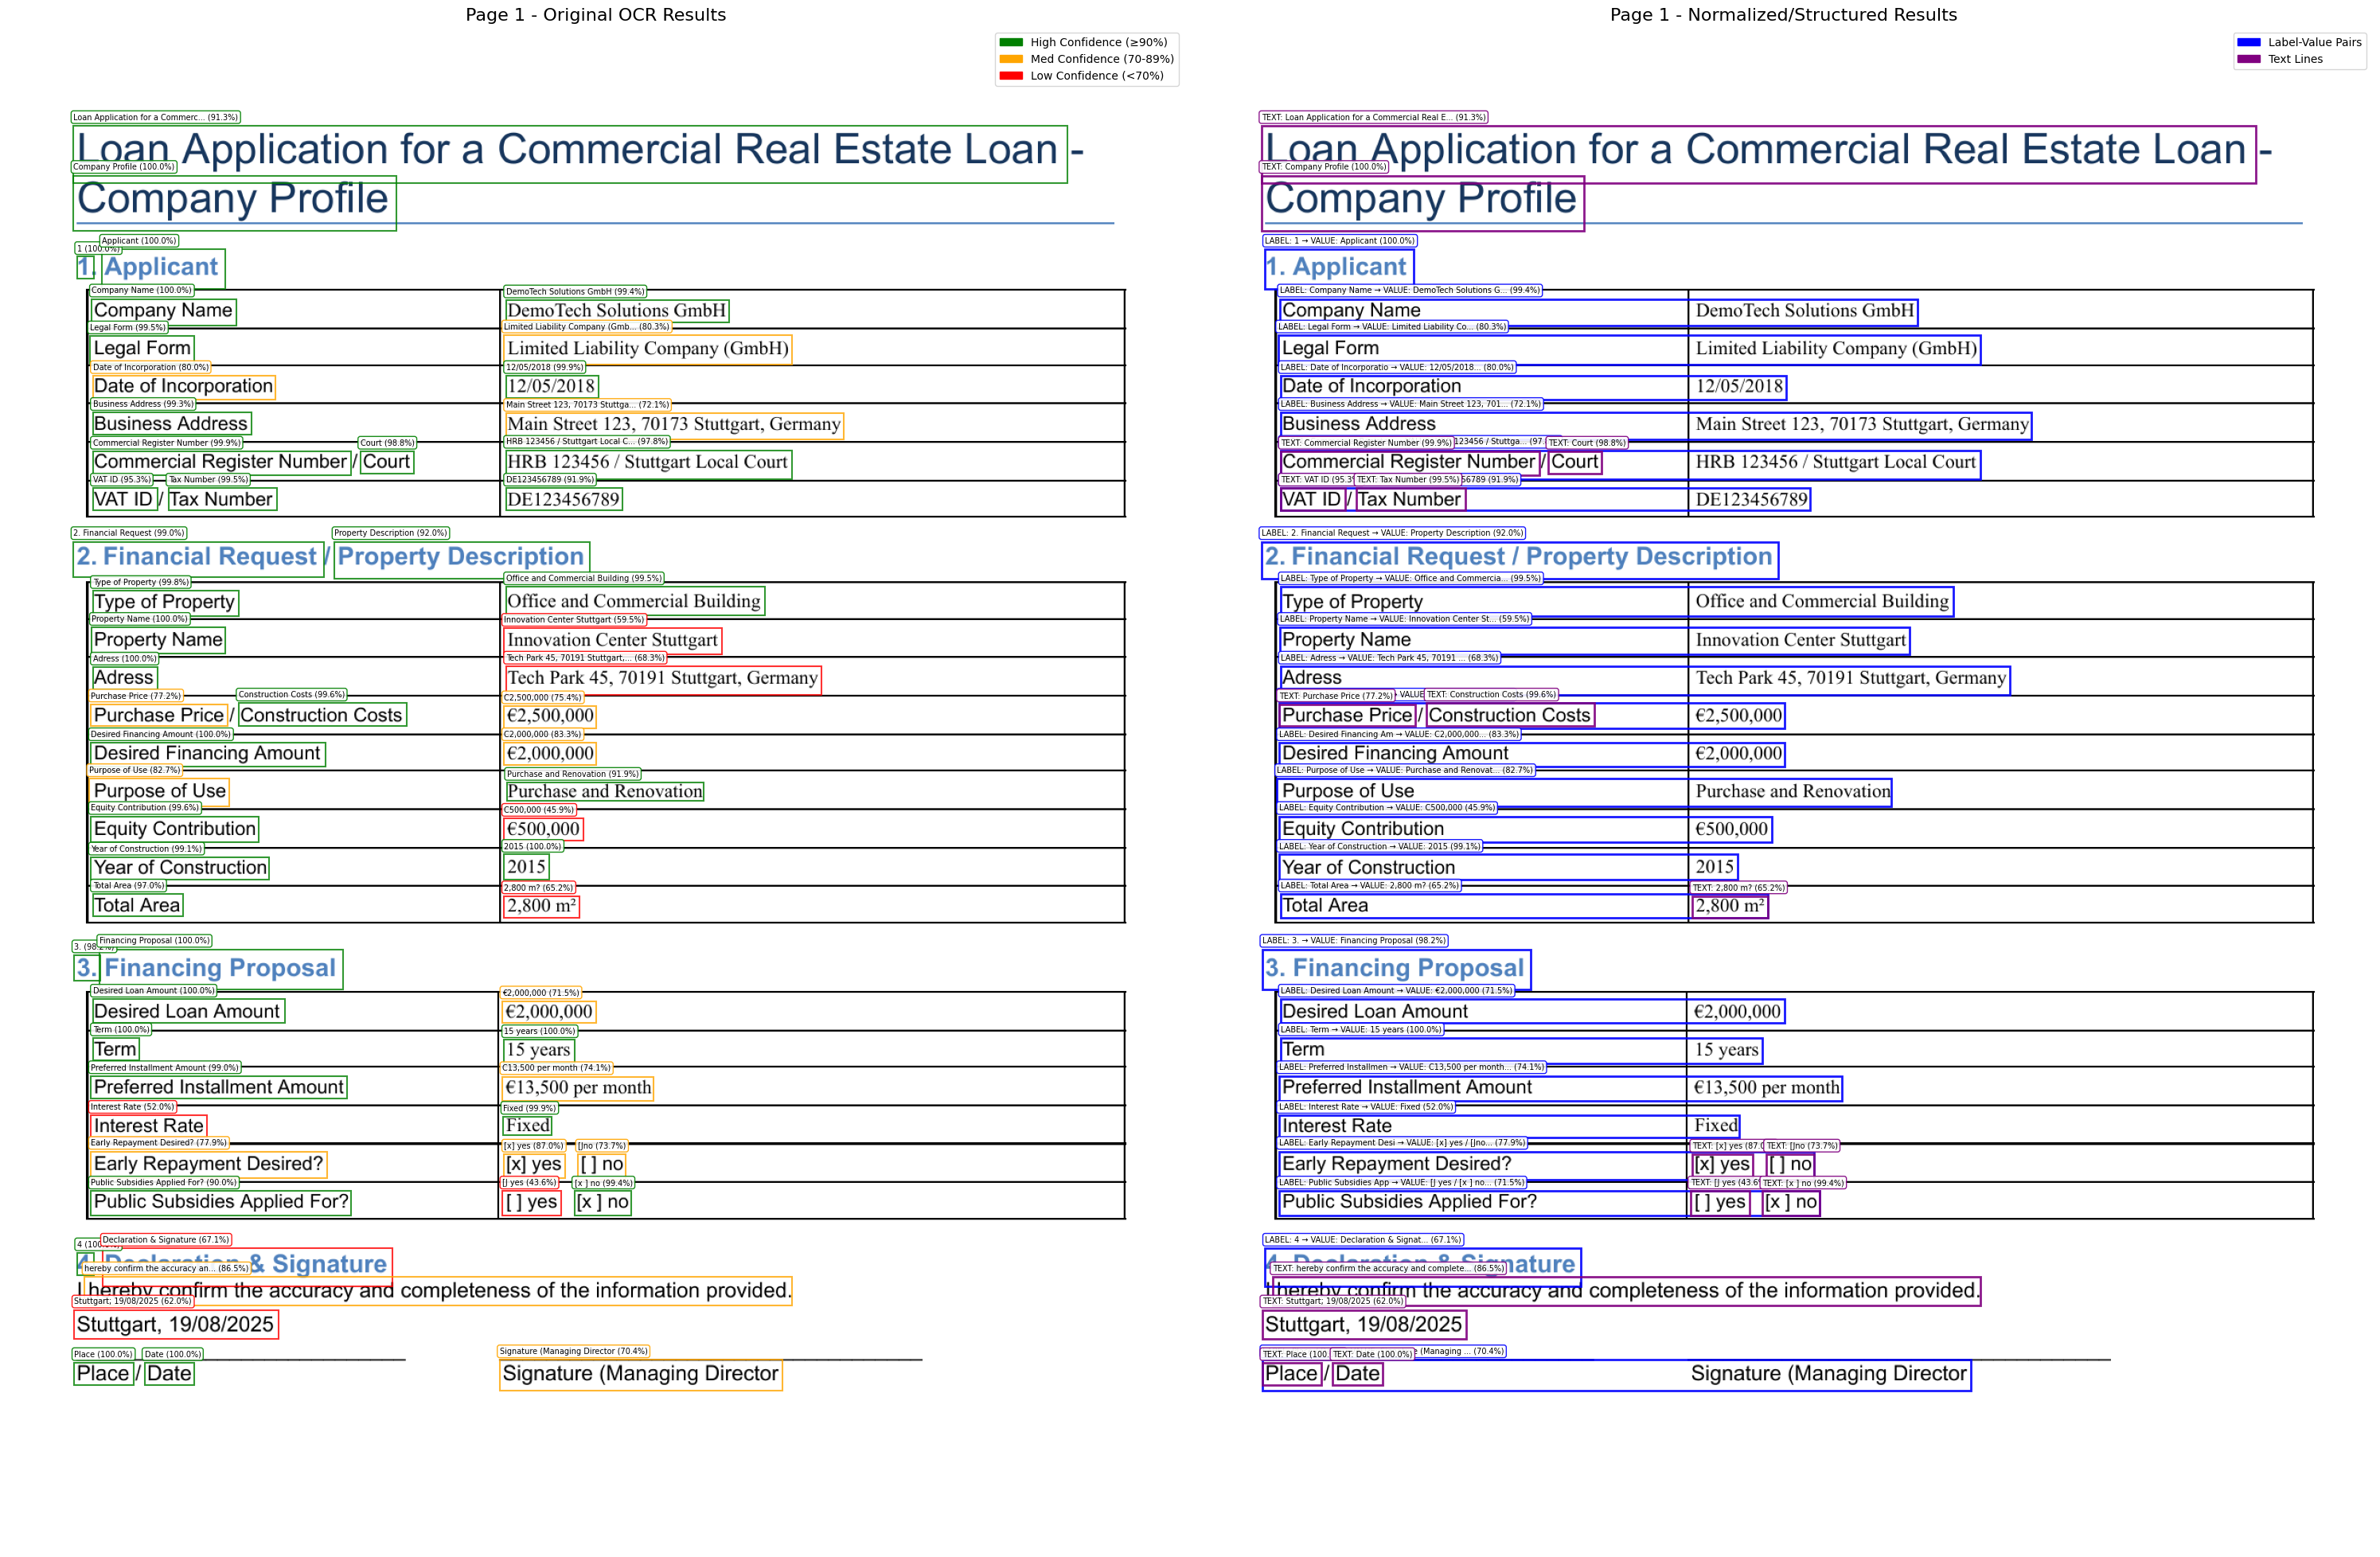

Page 1 Statistics:
  Original elements: 62
  Normalized elements: 43
    - Label-value pairs: 26
    - Text lines: 17
  Compression ratio: 69.4%



In [ ]:
def visualize_ocr_results(pdf_images: List[Any], ocr_results: List[Dict[str, Any]]) -> None:
    """Visualize OCR bounding boxes, text, and confidence on images."""
    page_to_elements: Dict[int, List[Dict[str, Any]]] = {}
    for result in ocr_results:
        page_num: int = result["page_num"]
        if page_num not in page_to_elements:
            page_to_elements[page_num] = []
        page_to_elements[page_num].append(result)
    for page_num, elements in page_to_elements.items():
        image = pdf_images[page_num - 1]
        fig, ax = plt.subplots(1, 1, figsize=(15, 20))
        ax.imshow(image)
        ax.set_title(f'Page {page_num} - OCR Text Extraction', fontsize=16)
        for element in elements:
            bbox = element['bbox']
            text = element['text']
            confidence = element['confidence']
            color = 'green' if confidence >= 0.9 else 'orange' if confidence >= 0.7 else 'red'
            rect = patches.Rectangle(
                (bbox['x1'], bbox['y1']),
                bbox['width'],
                bbox['height'],
                linewidth=1.5,
                edgecolor=color,
                facecolor='none',
                alpha=0.8
            )
            ax.add_patch(rect)
            display_text = text[:30] + ('...' if len(text) > 30 else '')
            label = f"{display_text} ({confidence*100:.1f}%)"
            ax.annotate(
                label,
                (bbox['x1'], bbox['y1'] - 5),
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=color, alpha=0.9),
                fontsize=7,
                color='black',
                ha='left',
                va='bottom'
            )
        legend_elements = [
            patches.Patch(color='green', label='High (≥90%)'),
            patches.Patch(color='orange', label='Med (70-89%)'),
            patches.Patch(color='red', label='Low (<70%)')
        ]
        ax.legend(handles=legend_elements, loc='upper right')
        ax.set_xlim(0, image.width)
        ax.set_ylim(image.height, 0)
        ax.axis('off')
        plt.tight_layout()
        plt.show()
        high = sum(1 for e in elements if e['confidence'] >= 0.9)
        med = sum(1 for e in elements if 0.7 <= e['confidence'] < 0.9)
        low = sum(1 for e in elements if e['confidence'] < 0.7)
        avg = sum(e['confidence'] for e in elements) / len(elements) if elements else 0
        print(f"Page {page_num}: {len(elements)} elements | Avg: {avg*100:.1f}% | H:{high} M:{med} L:{low}")
        
def visualize_cleaned_ocr_results(cleaned_results: Dict[str, Any], pdf_images: List[Any]) -> None:
    """Visualize cleaned OCR results with both original and normalized data on images."""
    
    # Extract data from cleaned results
    original_lines = cleaned_results["original_lines"]
    normalized_lines = cleaned_results["normalized_lines"]
    
    # Group original lines by page
    page_to_original: Dict[int, List[Dict[str, Any]]] = {}
    for result in original_lines:
        page_num: int = result["page_num"]
        if page_num not in page_to_original:
            page_to_original[page_num] = []
        page_to_original[page_num].append(result)
    
    # Group normalized lines by page
    page_to_normalized: Dict[int, List[Dict[str, Any]]] = {}
    for result in normalized_lines:
        page_num: int = result["page"]
        if page_num not in page_to_normalized:
            page_to_normalized[page_num] = []
        page_to_normalized[page_num].append(result)
    
    # Create visualizations for each page
    for page_num in page_to_original.keys():
        original_elements = page_to_original.get(page_num, [])
        normalized_elements = page_to_normalized.get(page_num, [])
        
        if page_num <= len(pdf_images):
            image = pdf_images[page_num - 1]
            
            # Create subplots for comparison
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 20))
            
            # Left plot: Original OCR results
            ax1.imshow(image)
            ax1.set_title(f'Page {page_num} - Original OCR Results', fontsize=16)
            
            for element in original_elements:
                bbox = element['bbox']
                text = element['text']
                confidence = element['confidence']
                
                # Color based on confidence
                color = 'green' if confidence >= 0.9 else 'orange' if confidence >= 0.7 else 'red'
                
                rect = patches.Rectangle(
                    (bbox['x1'], bbox['y1']),
                    bbox['width'],
                    bbox['height'],
                    linewidth=1.5,
                    edgecolor=color,
                    facecolor='none',
                    alpha=0.8
                )
                ax1.add_patch(rect)
                
                display_text = text[:30] + ('...' if len(text) > 30 else '')
                label = f"{display_text} ({confidence*100:.1f}%)"
                ax1.annotate(
                    label,
                    (bbox['x1'], bbox['y1'] - 5),
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=color, alpha=0.9),
                    fontsize=7,
                    color='black',
                    ha='left',
                    va='bottom'
                )
            
            # Right plot: Normalized results
            ax2.imshow(image)
            ax2.set_title(f'Page {page_num} - Normalized/Structured Results', fontsize=16)
            
            for element in normalized_elements:
                bbox = element['bounding_box']
                confidence = element['confidence']
                
                # Different colors for different types
                if element['type'] == 'label_value':
                    color = 'blue'
                    text_display = f"LABEL: {element['label'][:20]} → VALUE: {element['value'][:20]}"
                    if len(element['label']) > 20 or len(element['value']) > 20:
                        text_display += "..."
                else:  # text_line
                    color = 'purple'
                    text_display = f"TEXT: {element['text'][:40]}"
                    if len(element['text']) > 40:
                        text_display += "..."
                
                rect = patches.Rectangle(
                    (bbox['x1'], bbox['y1']),
                    bbox['width'],
                    bbox['height'],
                    linewidth=2,
                    edgecolor=color,
                    facecolor='none',
                    alpha=0.9
                )
                ax2.add_patch(rect)
                
                label = f"{text_display} ({confidence*100:.1f}%)"
                ax2.annotate(
                    label,
                    (bbox['x1'], bbox['y1'] - 5),
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=color, alpha=0.9),
                    fontsize=7,
                    color='black',
                    ha='left',
                    va='bottom'
                )
            
            # Add legends
            original_legend = [
                patches.Patch(color='green', label='High Confidence (≥90%)'),
                patches.Patch(color='orange', label='Med Confidence (70-89%)'),
                patches.Patch(color='red', label='Low Confidence (<70%)')
            ]
            ax1.legend(handles=original_legend, loc='upper right')
            
            normalized_legend = [
                patches.Patch(color='blue', label='Label-Value Pairs'),
                patches.Patch(color='purple', label='Text Lines')
            ]
            ax2.legend(handles=normalized_legend, loc='upper right')
            
            # Set plot properties
            for ax in [ax1, ax2]:
                ax.set_xlim(0, image.width)
                ax.set_ylim(image.height, 0)
                ax.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # Print statistics for this page
            original_count = len(original_elements)
            normalized_count = len(normalized_elements)
            label_value_count = sum(1 for e in normalized_elements if e['type'] == 'label_value')
            text_line_count = sum(1 for e in normalized_elements if e['type'] == 'text_line')
            
            print(f"Page {page_num} Statistics:")
            print(f"  Original elements: {original_count}")
            print(f"  Normalized elements: {normalized_count}")
            print(f"    - Label-value pairs: {label_value_count}")
            print(f"    - Text lines: {text_line_count}")
            print(f"  Compression ratio: {normalized_count/original_count*100:.1f}%")
            print()

In [ ]:
# Create side-by-side comparison of original vs normalized results
visualize_cleaned_ocr_results(cleaned_ocr_results, pdf_images)

---

## Summary

### What We've Accomplished

✅ **EasyOCR Integration**: Successfully extracted text with precise bounding boxes  
✅ **Spatial Analysis**: Implemented row detection and proximity-based grouping  
✅ **Text Reconstruction**: Merged split elements like "VAT ID / Tax Number"  
✅ **Label-Value Pairing**: Automatically detected and paired related information  
✅ **Visualization**: Created clear visual representations of OCR results  

### Key Metrics from Our Processing

- **Compression Ratio**: ~69% reduction from raw OCR to structured pairs
- **Detection Accuracy**: High confidence scores (>0.9) for most elements
- **Spatial Coverage**: Successfully mapped spatial relationships across document regions

### Processing Pipeline Summary

1. **PDF → Images**: Convert document pages to high-resolution images
2. **EasyOCR**: Extract text with bounding boxes and confidence scores
3. **Spatial Analysis**: Group nearby elements and detect row structures
4. **Text Reconstruction**: Merge split elements using proximity and alignment
5. **Label-Value Pairing**: Identify and pair related information
6. **Visualization**: Display results with bounding box overlays

**Next Steps:**
- Integration with LLM services for semantic analysis
- Database storage of extracted structured data
- Advanced table parsing for complex financial documents
- Real-time processing pipeline implementation


### Quick Reference: Key Functions

**Main Processing Functions:**
```python
# Extract raw OCR data
ocr_results, pdf_images = extract_text_bboxes_with_ocr(pdf_path)

# Convert to structured format
normalized_results = normalize_ocr_lines(ocr_results)

# Visualize results
visualize_ocr_results(ocr_results, pdf_images)
visualize_cleaned_ocr_results(cleaned_ocr_results, pdf_images)
```

**Data Structure:**
- **Raw OCR**: `[{'text': str, 'bbox': dict, 'confidence': float, 'page_num': int}, ...]`
- **Normalized**: `[{'type': 'label_value'|'text_line', 'label': str, 'value': str, ...}, ...]`

**Configuration Options:**
- `dpi=150`: Image resolution for PDF conversion
- `tolerance=15.0`: Row detection sensitivity  
- `similarity_threshold=0.3`: Text matching sensitivity

Continue to the next notebook for LLM integration and semantic analysis!
